
# 01 — Data Preparation (Pull + Clean Verification)

This notebook documents the **data collection and cleaning** steps for our NBA Team Outcomes project.  
It **verifies** that the processed dataset is ready for EDA and modeling.

**What this notebook does**
- Loads **raw** and **cleaned** datasets.
- Shows quick **before/after** previews.
- Runs **sanity checks** (rows, games, missing values).
- Verifies key **engineered features**: `home`, `rest_days`, and `opponent_*` columns.
- Saves a small summary CSV for the midterm README if needed.


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Notebook assumed to live in `notebooks/`
RAW_PATH = Path("../data/raw/team_gamelogs.csv")
CLEAN_PATH = Path("../data/processed/team_games_clean.csv")
IMG_DIR = Path("../img")
IMG_DIR.mkdir(parents=True, exist_ok=True)

print("Raw path exists:", RAW_PATH.exists())
print("Clean path exists:", CLEAN_PATH.exists())


Raw path exists: True
Clean path exists: True


## 1) Load raw and cleaned data

In [6]:

raw = pd.read_csv(RAW_PATH, dtype={"GAME_ID": str})
df  = pd.read_csv(CLEAN_PATH, parse_dates=["game_date"])

print("Raw shape:", raw.shape)
print("Clean shape:", df.shape)
print("Unique games (clean):", df["game_id"].nunique())
print("Date range (clean):", df["game_date"].min(), "→", df["game_date"].max())

raw.head(3)


Raw shape: (3516, 28)
Clean shape: (3514, 35)
Unique games (clean): 1757
Date range (clean): 2023-10-24 00:00:00 → 2024-04-14 00:00:00


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22023,1.610613e+09,PHI,Philadelphia 76ers,0022301192,2024-04-14,PHI vs. BKN,W,240,107,...,0.733,13,44,57,30,8,6,12,16,21.0
1,22023,1.610613e+09,SAS,San Antonio Spurs,0022301197,2024-04-14,SAS vs. DET,W,241,123,...,0.714,12,42,54,33,9,3,13,17,28.0
2,22023,1.610613e+09,NYK,New York Knicks,0022301190,2024-04-14,NYK vs. CHI,W,265,120,...,0.762,16,37,53,27,7,6,21,17,1.0


## 2) Compare columns (raw vs. clean)

In [7]:

print("Raw columns (sample):", list(raw.columns[:15]), "...")
print("Clean columns (sample):", list(df.columns[:15]), "...")


Raw columns (sample): ['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A'] ...
Clean columns (sample): ['season_id', 'team_id', 'team_abbreviation', 'team_name', 'game_id', 'game_date', 'matchup', 'wl', 'pts', 'fg_pct', 'fga', 'fgm', 'fg3m', 'fg3a', 'fg3_pct'] ...


## 3) Sanity checks

In [8]:

pair_counts = df.groupby("game_id")["team_id"].nunique()
print("Team-rows per game distribution:\n", pair_counts.value_counts())

bad_games = pair_counts[pair_counts != 2]
print("Games without 2 teams:", list(bad_games.index))

print("Top null counts:\n", df.isna().sum().sort_values(ascending=False).head(10))

print("\nDtypes:")
print(df.dtypes.head(15))


Team-rows per game distribution:
 team_id
2    1757
Name: count, dtype: int64
Games without 2 teams: []
Top null counts:
 ft_pct        1
plus_minus    0
reb           0
ast           0
stl           0
blk           0
tov           0
pf            0
home          0
oreb          0
dtype: int64

Dtypes:
season_id                     int64
team_id                     float64
team_abbreviation            object
team_name                    object
game_id                       int64
game_date            datetime64[ns]
matchup                      object
wl                           object
pts                           int64
fg_pct                      float64
fga                           int64
fgm                           int64
fg3m                          int64
fg3a                          int64
fg3_pct                     float64
dtype: object


## 4) Feature verification — `home`, `rest_days`, `opponent_*`

In [9]:

cols_needed = {
    "home", "rest_days", "pts",
    "opponent_pts", "opponent_fg_pct", "opponent_reb", "opponent_tov"
}
print("Have all key columns? ->", cols_needed.issubset(df.columns))

display(df[["team_abbreviation","opponent_team_abbreviation","home","rest_days","pts","opponent_pts"]].head(10))


Have all key columns? -> True


,team_abbreviation,opponent_team_abbreviation,home,rest_days,pts,opponent_pts
0,DEN,LAL,1,3.0,119,107
1,LAL,DEN,0,3.0,107,119
2,GSW,PHX,1,3.0,104,108
3,PHX,GSW,0,3.0,108,104
4,ATL,CHA,0,3.0,110,116
5,CHA,ATL,1,3.0,116,110
6,IND,WAS,1,3.0,143,120
7,WAS,IND,0,3.0,120,143
8,BOS,NYK,0,3.0,108,104
9,NYK,BOS,1,3.0,104,108


## 5) Save quick summary table for README (optional)

In [10]:

summary = (df.groupby("team_abbreviation")
             .agg(avg_pts=("pts","mean"),
                  avg_rest=("rest_days","mean"),
                  games=("game_id","nunique"))
             .sort_values("avg_pts", ascending=False)
             .reset_index())

summary_path = Path("../data/processed/team_summary.csv")
summary.to_csv(summary_path, index=False)
summary.head(10)


,team_abbreviation,avg_pts,avg_rest,games
0,IND,123.292683,2.134146,82
1,BOS,120.573171,2.134146,82
2,OSC,120.117647,2.764706,34
3,OKC,120.085366,2.134146,82
4,TEX,119.529412,2.852941,34
5,MIL,118.975610,2.121951,82
6,OKL,118.558824,2.852941,34
7,BHM,118.470588,2.794118,34
8,ATL,118.329268,2.134146,82
9,LAL,118.036585,2.146341,82


## 6) Quick preview plot (full EDA will be `02_eda.ipynb`)

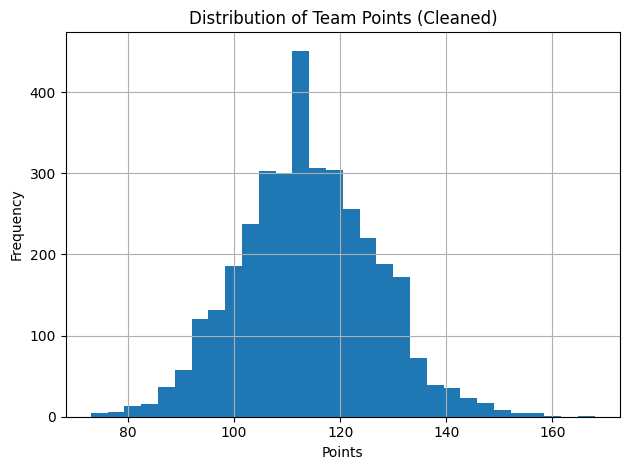

Saved preview plot to: ../img/prep_pts_hist.png


In [11]:

plt.figure()
df["pts"].hist(bins=30)
plt.title("Distribution of Team Points (Cleaned)")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(IMG_DIR / "prep_pts_hist.png", dpi=120)
plt.show()

print("Saved preview plot to:", IMG_DIR / "prep_pts_hist.png")



## 7) Conclusions (for midterm README)

- **Data pull** succeeded for the season; raw contains one row per team-game.
- **Cleaning/feature engineering** completed:
  - normalized columns
  - parsed `game_date`
  - added `home` (1=home, 0=away) and `rest_days`
  - attached opponent stats (`opponent_*`)
  - filtered out any games not having exactly two team rows
- **Dataset is ready** for EDA and baseline regression in subsequent notebooks.
